In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(200, 200)

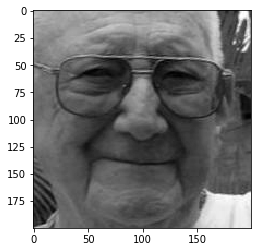

In [2]:
import cv2

image = cv2.imread('UTKFace/101_0_0_20170112213500903.jpg.chip.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('UTKFace/foo.jpg', image_gray)
plt.imshow(image_gray, cmap=plt.get_cmap('gray'))
image_gray.shape

### See how many images we have in each category

In [5]:
import os
chart = [0 for x in range(11)]
file_list = os.listdir('UTKFace')
for f in file_list:
    split_f = f.split('_')
    index = int(split_f[0],10)
    if index >= 0 and index <= 2:
        index = 0 # use 0 to represent 0-2
    elif index >= 3 and index <= 12:
        index = 1 # use 1 to represent 3-12
    elif index >= 13 and index <= 19:
        index = 2 # use 2 to represent 13-19
    elif index >= 20 and index <= 29:
        index = 3 # use 3 to represent 20-29
    elif index >= 30 and index <= 39:
        index = 4 # use 4 to represent 30-39
    if index >= 40 and index <= 49:
        index = 5 # use 5 to represent 40-49
    elif index >= 50 and index <= 59:
        index = 6 # use 6 to represent 50-59
    elif index >= 60 and index <= 69:
        index = 7
    elif index >= 70 and index <= 79:
        index = 8
    elif index >= 80 and index <= 89:
        index = 9
    elif index >= 90:
        index = 10

    chart[index] += 1
# display number of image we have for each age
for i in range(len(chart)):
    print(i, ":", chart[i])

0 : 1605
1 : 1808
2 : 1180
3 : 7344
4 : 4537
5 : 2245
6 : 2299
7 : 1318
8 : 699
9 : 504
10 : 169


### Load Data

In [3]:
batch_size = 32
num_workers = 1

# NOTE we can change the input channel from 3 to 1 here
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])
train_data = torchvision.datasets.ImageFolder('new_UTKFace/train', transform=transform)
val_data = torchvision.datasets.ImageFolder('new_UTKFace/validation', transform=transform)
test_data = torchvision.datasets.ImageFolder('new_UTKFace/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(len(train_loader), len(val_loader), len(test_loader))

519 112 111


In [4]:
# Check shape
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)

training: torch.Size([32, 1, 128, 128]) torch.Size([32])


### Define our model

In [6]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = "AgeNet"
        # input layer is 1*128*128
        self.conv1 = nn.Conv2d(1, 5, 5, stride = 1, padding = 2) # output layer is 5*64*64
        self.pool1 = nn.MaxPool2d(4, 4) # output layer is 5*32*32
        self.conv2 = nn.Conv2d(5, 10, 5, stride = 1, padding = 2) # output layer is 10*32*32
        self.pool2 = nn.MaxPool2d(2, 2)  # output layer is 10*16*16
        self.conv3 = nn.Conv2d(10, 20, 5, stride = 1, padding = 2) # output layer is 20*16*16
        self.fc1 = nn.Linear(20*16*16, 128) # outputing 128
        self.fc2 = nn.Linear(128, 11)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
# function that calculates the accuracy
def get_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# function that gets the validation loss
def get_val_loss(model, criterion, val_loader):
    total_loss = 0
    total = 0
    for imgs, labels in iter(val_loader):
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)             # forward pass
        prob = F.softmax(output, dim=1)
        loss = criterion(output, labels) # compute the total loss
        total_loss += loss.item()
        total += imgs.shape[0]
    return total_loss / total

# function to train the model
def train(model, train_data, batch_size=32, lr=0.01, num_epochs=1, is_overfit=False):
#     torch.manual_seed(2) # set the random seed
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    if is_overfit:
        overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss() # use cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr) # use adam optimizer

    iters, train_acc, train_loss, val_acc, val_loss = [], [], [], [], []
    best_val_loss = 0

    # training
    print("training now...")
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            output = model(imgs)             # forward pass
            prob = F.softmax(output, dim=1)
            loss = criterion(output, labels) # compute the total loss
            loss = loss.float()
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        this_train_loss = float(loss)/batch_size
        train_loss.append(this_train_loss)    # compute *average* loss
        this_val_loss = get_val_loss(model, criterion, val_loader)
        val_loss.append(this_val_loss)
        
        if is_overfit:
            training_accuracy = get_accuracy(model, overfit_loader, batch_size)
            train_acc.append(training_accuracy)
            validation_accuracy = get_accuracy(model, overfit_loader, batch_size)
            val_acc.append(validation_accuracy)
        else:
            training_accuracy = get_accuracy(model, train_loader, batch_size)
            train_acc.append(training_accuracy) # compute training accuracy
            validation_accuracy = get_accuracy(model, val_loader, batch_size)
            val_acc.append(validation_accuracy)
        
        if this_val_loss < best_val_loss: # update best validation loss
            best_val_loss = this_val_loss
            torch.save(model.state_dict(), 'models/model8.pth') # save the best model
        
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, training_accuracy, validation_accuracy))
#         print("Epoch {} - Training Loss: {}, Validation Loss: {}".format(
#             epoch, this_train_loss, this_val_loss))
        n += 1

    # plotting
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
#     print("Final Training Loss: {}".format(train_acc[-1]))
#     print("Final Validation Loss: {}".format(val_acc[-1]))

### Train on different params

In [8]:
use_cuda = torch.cuda.is_available()

In [8]:
model = AgeNet()
# use_cuda = 0
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=30)

training now...


KeyboardInterrupt: 

In [ ]:
model1 = AgeNet()
# use_cuda = 0
if use_cuda:
    model1 = model1.cuda()
train(model1, train_data, batch_size=32, lr=0.0001, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.32166736943557617, Validation Accuracy: 0.32321528948847666
Epoch 1 - Training Accuracy: 0.36292994397927836, Validation Accuracy: 0.3625632377740304
Epoch 2 - Training Accuracy: 0.4137702548039275, Validation Accuracy: 0.40978077571669475
Epoch 3 - Training Accuracy: 0.4317209806638154, Validation Accuracy: 0.42242833052276557
Epoch 4 - Training Accuracy: 0.45178001325221373, Validation Accuracy: 0.4418212478920742
Epoch 5 - Training Accuracy: 0.45858683211854706, Validation Accuracy: 0.4457560427206296
Epoch 6 - Training Accuracy: 0.46497198963917835, Validation Accuracy: 0.44435075885328834
Epoch 7 - Training Accuracy: 0.464490090958376, Validation Accuracy: 0.45165823496346263
Epoch 8 - Training Accuracy: 0.4686464670802964, Validation Accuracy: 0.44997189432265317
Epoch 9 - Training Accuracy: 0.48057345943015484, Validation Accuracy: 0.46149522203485105
Epoch 10 - Training Accuracy: 0.49527136919462683, Validation Accuracy: 0.47779651

In [10]:
model5 = AgeNet()
# use_cuda = 0
if use_cuda:
    model5 = model2.cuda()
train(model5, train_data, batch_size=32, lr=0.0005, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.3937112222155292, Validation Accuracy: 0.3898257448004497
Epoch 1 - Training Accuracy: 0.44117824227456176, Validation Accuracy: 0.433389544688027
Epoch 2 - Training Accuracy: 0.4752725739413288, Validation Accuracy: 0.4575604272062957
Epoch 3 - Training Accuracy: 0.4843081742063731, Validation Accuracy: 0.45812254075323217
Epoch 4 - Training Accuracy: 0.5038250707788687, Validation Accuracy: 0.4645868465430017
Epoch 5 - Training Accuracy: 0.5370158424191314, Validation Accuracy: 0.485947161326588
Epoch 6 - Training Accuracy: 0.5424974399132583, Validation Accuracy: 0.4772344013490725
Epoch 7 - Training Accuracy: 0.5541232455876152, Validation Accuracy: 0.4831365935919056
Epoch 8 - Training Accuracy: 0.5940605987591109, Validation Accuracy: 0.491849353569421
Epoch 9 - Training Accuracy: 0.6095415938798867, Validation Accuracy: 0.4744238336143901
Epoch 10 - Training Accuracy: 0.6170712607674237, Validation Accuracy: 0.4724564362001124
Epoch

KeyboardInterrupt: 

In [12]:
model6 = AgeNet()
# use_cuda = 0
if use_cuda:
    model6 = model6.cuda()
train(model6, train_data, batch_size=32, lr=0.01, num_epochs=30)

training now...
Epoch 0 - Training Accuracy: 0.3416059273537739, Validation Accuracy: 0.33839235525576167
Epoch 1 - Training Accuracy: 0.36292994397927836, Validation Accuracy: 0.35694210230466555
Epoch 2 - Training Accuracy: 0.3785916511053551, Validation Accuracy: 0.37155705452501403
Epoch 3 - Training Accuracy: 0.4294921992651045, Validation Accuracy: 0.41174817313097245
Epoch 4 - Training Accuracy: 0.4273838925365942, Validation Accuracy: 0.40191118605958404
Epoch 5 - Training Accuracy: 0.4445515330401783, Validation Accuracy: 0.4196177627880832
Epoch 6 - Training Accuracy: 0.4694897897717005, Validation Accuracy: 0.42411467116357504
Epoch 7 - Training Accuracy: 0.4932232998012168, Validation Accuracy: 0.44013490725126475
Epoch 8 - Training Accuracy: 0.4694897897717005, Validation Accuracy: 0.40893760539629004


KeyboardInterrupt: 

## The Best Model we have
This one has the highest validation accuracy

And we saved the epoch with the highest validation accuracy

In [ ]:
model8 = AgeNet()
# use_cuda = 0
if use_cuda:
    model8 = model8.cuda()
train(model8, train_data, batch_size=32, lr=0.001, num_epochs=30)

training now...


training now...
Epoch 0 - Training Accuracy: 0.4449129570507801, Validation Accuracy: 0.43816750983698705
Epoch 1 - Training Accuracy: 0.46979097644720197, Validation Accuracy: 0.4617762788083193
Epoch 2 - Training Accuracy: 0.5096680922835973, Validation Accuracy: 0.48538504777965147
Epoch 3 - Training Accuracy: 0.5371965544244323, Validation Accuracy: 0.5084317032040472
Epoch 4 - Training Accuracy: 0.547135714715981, Validation Accuracy: 0.49353569421023047
Epoch 5 - Training Accuracy: 0.5836395397867599, Validation Accuracy: 0.5118043844856661
Epoch 6 - Training Accuracy: 0.6100234925606891, Validation Accuracy: 0.508150646430579
Epoch 7 - Training Accuracy: 0.6402626347810373, Validation Accuracy: 0.4963462619449129
Epoch 8 - Training Accuracy: 0.6514065417745919, Validation Accuracy: 0.48369870713884205
Epoch 9 - Training Accuracy: 0.6777302572134208, Validation Accuracy: 0.4822934232715008
Epoch 10 - Training Accuracy: 0.7386904403349196, Validation Accuracy: 0.4741427768409219
E

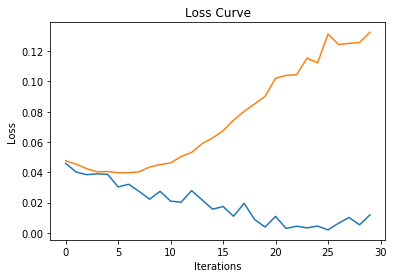

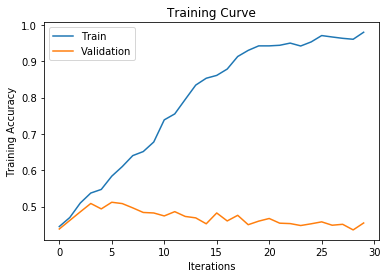

Final Training Loss: 0.980001204746702
Final Validation Loss: 0.4547498594716133


In [10]:
model7 = AgeNet()
# use_cuda = 0
if use_cuda:
    model7 = model7.cuda()
train(model7, train_data, batch_size=32, lr=0.001, num_epochs=30)

### Test

In [13]:
# Get test accuracy 
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.cuda().eval()

test_accuracy = get_accuracy(final_model, test_loader, batch_size)
test_accuracy

0.463229078613694

tensor([5.9307e-16, 3.0407e-17, 6.2578e-07, 1.2619e-18, 4.8466e-03, 8.6997e-01,
        2.1569e-02, 1.0359e-01, 2.5493e-05, 2.2222e-10, 3.5325e-17],
       grad_fn=<SelectBackward>)
Predicted Age Group: 40-49
Actual Age Group: 40-49


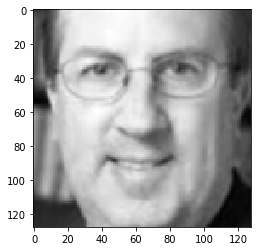

In [20]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", age_group[pred[0].item()])
print("Actual Age Group:", age_group[labels[0].item()])

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

In [7]:
# List our age groups
age_group = os.listdir("new_UTKFace/test")
age_group

['0-2',
 '13-19',
 '20-29',
 '3-12',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80-89',
 '90+']

### Less Restricted Accuracy

In [57]:
# function that calculates the accuracy
def get_less_restricted_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        
        # changing them for easier "math" later
        for i in range(labels.shape[0]):
            if labels[i] == 3:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 2
            elif labels[i] == 2:
                labels[i] = 3
            
            if pred[i] == 3:
                pred[i] = 1
            elif pred[i] == 1:
                pred[i] = 2
            elif pred[i] == 2:
                pred[i] = 3
        
        for i in range(imgs.shape[0]):
            if abs(pred[i] - labels[i].view_as(pred[i])) <= 1:
                correct += 1
                
        total += imgs.shape[0]
    return correct / total

In [58]:
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.cuda().eval()

less_restricted_test_accuracy = get_less_restricted_accuracy(final_model, test_loader, batch_size)
less_restricted_test_accuracy

0.8224852071005917

### Load my own data
am still working on it haha

In [ ]:
import cv2
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])
my_data = torchvision.datasets.ImageFolder('my_data', transform=transform)
my_loader = torch.utils.data.DataLoader(my_data, batch_size=1)
myiter = iter(my_loader)
imgs, labels = myiter.next()

# load my final model
final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()

Predicted Age Group: 70-79
Actual Age Group: 90+


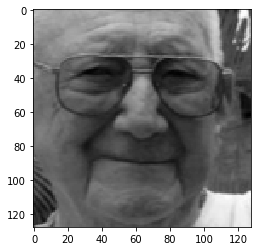

In [80]:
# see what my model's prediction is
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
# print(prob[0])
print("Predicted Age Group:", age_group[pred[0].item()])
print("Actual Age Group:", age_group[labels[0].item()])

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.reshape(-1,128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))